# Анализ тональности текста комментариев в социальных сетях для выявления негативных и положительных эмоций
# Выполнил Сергачев Данила Дмитриевич
## Получение данных
Для реализации задания были взяты данные из открытого датасета Linis Crowd, который содержит 29 тысяч размеченных текстов – наиболее крупный датасет для неформальных текстов на русском языке. Данные содержали классификацию текстов по шкале от -2 до 2. Во время первого прогона алгоритмов качество предсказания классов было на низком уровне из-за чего было решено сократить количество классов до 3: -1 до 1

Ссылка на датасет:
http://linis-crowd.org/static/collection_(docs_words)_2016_all_labels.zip

In [ ]:
!wget 'http://linis-crowd.org/static/collection_(docs_words)_2016_all_labels.zip'
    
!unzip 'collection_(docs_words)_2016_all_labels.zip'

--2022-02-21 07:51:42--  http://linis-crowd.org/static/collection_(docs_words)_2016_all_labels.zip
Resolving linis-crowd.org (linis-crowd.org)... 5.23.51.104, 2a03:6f00:6:1::517:3368
Connecting to linis-crowd.org (linis-crowd.org)|5.23.51.104|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11973715 (11M) [application/zip]
Saving to: ‘collection_(docs_words)_2016_all_labels.zip.1’

collection_(docs_wo 100%[===================>]  11.42M   207KB/s    in 43s     

2022-02-21 07:52:26 (271 KB/s) - ‘collection_(docs_words)_2016_all_labels.zip.1’ saved [11973715/11973715]

Archive:  collection_(docs_words)_2016_all_labels.zip
  inflating: collection (docs&words)_2016_all_labels/doc_comment_summary.xlsx  
  inflating: collection (docs&words)_2016_all_labels/full word_rating_after_coding.xlsx  


## Установка дополнительных пакетов

In [ ]:
!pip install openpyxl
!pip install catboost

     |████████████████████████████████| 76.1 MB 67 kB/s 


## Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn import metrics

from catboost import CatBoostClassifier, Pool

from catboost import MetricVisualizer

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = 16, 10

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('russian'))
lemmatizer = WordNetLemmatizer()

expected_classes = [-2, -1, 0, 1, 2]

from google.colab import output
output.disable_custom_widget_manager()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Функции для предварительной обработки текста

In [ ]:
def preprocess(text):
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = list(lemmatizer.lemmatize(word) for word in text)
    text = list(word for word in text if word not in stop_words)
    
    return text

def transform_lable(lable):
    if lable == 0:
        return 0
    elif lable > 0:
        return 1
    else:
        return -1

## Чтение данных

In [ ]:
df = pd.read_excel('collection (docs&words)_2016_all_labels/doc_comment_summary.xlsx', names=['raw_text', 'lable']) 
df = df[df['lable'].isin(expected_classes)]
df['lable'] = df['lable'].apply(transform_lable)
df = df.dropna()
df['text'] = df['raw_text'].apply(preprocess)

df

,raw_text,lable,text
0,Украина это часть Руси искусственно отделенная...,-1,"[украина, это, часть, руси, искусственно, отде..."
1,Как можно говорить об относительно небольшой к...,-1,"[говорить, относительно, небольшой, коррупции,..."
2,1.2014. а что они со своими поляками сделали?...,0,"[своими, поляками, сделали, русских, понятно, ..."
3,у а фильмы... Зрители любят диковинное. у ме...,0,"[фильмы, зрители, любят, диковинное, соседка, ..."
4,Государство не может сейчас платить больше и м...,-1,"[государство, платить, посмотрите, денежный, п..."
...,...,...,...
26867,Многих заставляют. Многие сами проявляют излиш...,-1,"[многих, заставляют, многие, сами, проявляют, ..."
26868,Очередной Чубайс. ну а чего нового то? Сорос ...,-1,"[очередной, чубайс, нового, сорос, дал, исчерп..."
26869,"Закон, как все предыдущие - абсолютный бред и ...",0,"[закон, предыдущие, абсолютный, бред, нежелани..."
26870,дело которое ты делаешь сейчас - оно очень хор...,0,"[дело, которое, делаешь, оно, очень, хорошее, ..."


## Векторизация предложений на основе Word2Vec
### Модель Word2Vec имеет множество аргументов:

- min_count — игнорировать все слова с частотой встречаемости меньше, чем это значение.
- windоw — размер контекстного окна, о котором говорили тут, обозначает диапазон контекста.
- size — размер векторного представления слова (word embedding).
- negative — сколько неконтекстных слов учитывать в обучении, используя negative sampling, о нем также упоминалось здесь.
- alpha — начальный learning_rate, используемый в алгоритме обратного распространения ошибки (Backpropogation).
- min_alpha — минимальное значение learning_rate, на которое может опуститься в процессе обучения.
- sg — если 1, то используется реализация Skip-gram; если 0, то CBOW. О реализациях также говорили тут.


In [ ]:
w2v_model = Word2Vec(
    min_count=5,
    window=2,
    size=300,
    negative=10,
    alpha=0.03,
    min_alpha=0.0007,
    sample=6e-5,
    sg=1)

w2v_model.build_vocab(df['text'])

In [ ]:
w2v_model.train(df['text'], total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
w2v_model.init_sims(replace=True)

In [ ]:
def transform_text(row, size=300):
    result = np.zeros(size)
    for word in row:
        if word not in w2v_model.wv.vocab.keys():
            continue 
        result += np.array(w2v_model.wv.get_vector(word), dtype=np.float64)
    
    return np.array(result, dtype=np.float64)

In [ ]:
df.groupby(['lable'])['raw_text'].count().reset_index(name='count')

,lable,count
0,-1,10734
1,0,13858
2,1,2159


## Разбиение выборки на тренировочную и тестовую и векторизация текста

In [ ]:
x = df['text']
y = df['lable']

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=777, stratify=y)

In [ ]:
X_train_transformed = X_train.apply(transform_text).reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_test_transformed = X_test.apply(transform_text).reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
X_train_transformed

0        [2.1479106977931224, 5.304265459533781, 2.3385...
1        [-1.0603335716878064, 4.363477365550352, 1.583...
2        [-1.2194679754320532, 3.819852960994467, 0.563...
3        [-1.0141794190276414, 2.452082736592274, 0.055...
4        [0.9599821707233787, 1.814620915800333, 0.6497...
                               ...                        
18720    [3.6799573437674553, 10.919709520007018, -0.92...
18721    [-0.5934225527453236, 2.1259460031287745, 0.28...
18722    [0.6649511974537745, 3.8650384936117916, 0.875...
18723    [1.6932550216297386, 3.3175247815670446, 1.287...
18724    [1.5434560784451605, 2.6554223351413384, -0.42...
Name: text, Length: 18725, dtype: object

## Использование LogisticRegression для классификации тональности текста

In [ ]:
log_model = LogisticRegression(C = 5, penalty='l2', max_iter=1000, random_state=12345, multi_class='multinomial')
log_model.fit(X_train_transformed.tolist(), y_train)

y_pred = log_model.predict(X_test_transformed.tolist())
y_pred_proba = log_model.predict_proba(X_test_transformed.tolist())

In [ ]:
print(f"Общая F1 = {metrics.f1_score(y_test, y_pred, average='micro')}")
print(f'ROC-AUC = {metrics.roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="macro")}')

Общая F1 = 0.6007974084226264
ROC-AUC = 0.7083727802070058


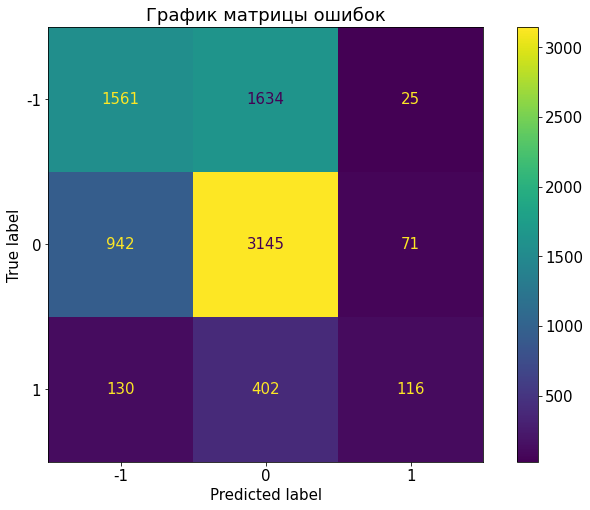

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title('График матрицы ошибок')

cm = metrics.confusion_matrix(y_test, y_pred)
cmp = metrics.ConfusionMatrixDisplay(cm, display_labels=log_model.classes_)
cmp.plot(ax=ax)

plt.show();

## Использование CatBoostClassifier для классификации тональности текста
### Сравнение модели с разными гипперпараметрами

In [ ]:
model_depth_3 = CatBoostClassifier(
    iterations=500,
    random_seed=63,
    learning_rate=0.07,
    depth=3,
    loss_function='MultiClass',
    custom_loss=['AUC', 'Accuracy', 'F1'],
    train_dir='model_depth_3'
)

model_depth_4 = CatBoostClassifier(
    iterations=500,
    random_seed=63,
    learning_rate=0.07,
    depth=4,
    loss_function='MultiClass',
    custom_loss=['AUC', 'Accuracy', 'F1'],
     train_dir='model_depth_4'
)

model_depth_5 = CatBoostClassifier(
    iterations=500,
    random_seed=63,
    learning_rate=0.07,
    depth=5,
    loss_function='MultiClass',
    custom_loss=['AUC', 'Accuracy', 'F1'],
     train_dir='model_depth_5'
)

model_depth_6 = CatBoostClassifier(
    iterations=500,
    random_seed=63,
    learning_rate=0.07,
    depth=6,
    loss_function='MultiClass',
    custom_loss=['AUC', 'Accuracy', 'F1'],
     train_dir='model_depth_6'
)


model_depth_3 = model_depth_3.fit(X_train_transformed, y_train, 
                  use_best_model=True, 
                  eval_set=(X_test_transformed, y_test), verbose=False)

model_depth_4 = model_depth_4.fit(X_train_transformed, y_train, 
                  use_best_model=True, 
                  eval_set=(X_test_transformed, y_test), verbose=False)

model_depth_5 = model_depth_5.fit(X_train_transformed, y_train, 
                  use_best_model=True, 
                  eval_set=(X_test_transformed, y_test), verbose=False)

model_depth_6 = model_depth_6.fit(X_train_transformed, y_train, 
                  use_best_model=True, 
                  eval_set=(X_test_transformed, y_test), verbose=False)

### Интерактивный график с метриками качества классификации и с визуализацией процесса обучения

In [ ]:
MetricVisualizer(['model_depth_3', 'model_depth_4', 'model_depth_5', 'model_depth_6']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
model_depth_6.classes_

array([-1,  0,  1])

### Лучшая модель на основе сравнения

In [ ]:
best_model = CatBoostClassifier(
    iterations=500,
    random_seed=63,
    learning_rate=0.07,
    depth=4,
    loss_function='MultiClass',
    custom_loss=['AUC', 'Accuracy', 'F1']
)


best_model = best_model.fit(X_train_transformed, y_train, 
                  use_best_model=True, 
                  eval_set=(X_test_transformed, y_test), 
                  verbose=40, plot=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.0760821	test: 1.0763606	best: 1.0763606 (0)	total: 124ms	remaining: 1m 1s
40:	learn: 0.8518075	test: 0.8606842	best: 0.8606842 (40)	total: 4.12s	remaining: 46.2s
80:	learn: 0.8219289	test: 0.8386939	best: 0.8386939 (80)	total: 8.1s	remaining: 41.9s
120:	learn: 0.8049171	test: 0.8279229	best: 0.8279229 (120)	total: 12s	remaining: 37.6s
160:	learn: 0.7906380	test: 0.8193330	best: 0.8193330 (160)	total: 15.8s	remaining: 33.3s
200:	learn: 0.7777118	test: 0.8130880	best: 0.8130880 (200)	total: 19.7s	remaining: 29.2s
240:	learn: 0.7668511	test: 0.8088243	best: 0.8087902 (239)	total: 23.6s	remaining: 25.4s
280:	learn: 0.7568456	test: 0.8053587	best: 0.8053587 (280)	total: 27.6s	remaining: 21.5s
320:	learn: 0.7478595	test: 0.8019650	best: 0.8019650 (320)	total: 31.4s	remaining: 17.5s
360:	learn: 0.7393118	test: 0.7998026	best: 0.7998026 (360)	total: 35.3s	remaining: 13.6s
400:	learn: 0.7315828	test: 0.7982352	best: 0.7981970 (399)	total: 39.2s	remaining: 9.69s
440:	learn: 0.7238869

## Сравнение алгоритмов LogisticRegression и CatBoostClassifier

In [ ]:
y_pred_boosting = best_model.predict(X_test_transformed.tolist())
y_pred_proba_boosting = best_model.predict_proba(X_test_transformed.tolist())

In [ ]:
print(f"Общая F1 для бустинга = {metrics.f1_score(y_test, y_pred_boosting, average='micro')}")
print(f"Общая F1 для логистической регрессии = {metrics.f1_score(y_test, y_pred, average='micro')}")
print()
print(f'ROC-AUC для бустинга = {metrics.roc_auc_score(y_test, y_pred_proba_boosting, multi_class="ovr", average="macro")}')
print(f'ROC-AUC для логистической регрессии = {metrics.roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="macro")}')

Общая F1 для бустинга = 0.6164963867430849
Общая F1 для логистической регрессии = 0.6007974084226264

ROC-AUC для бустинга = 0.7282848941150831
ROC-AUC для логистической регрессии = 0.7083727802070058


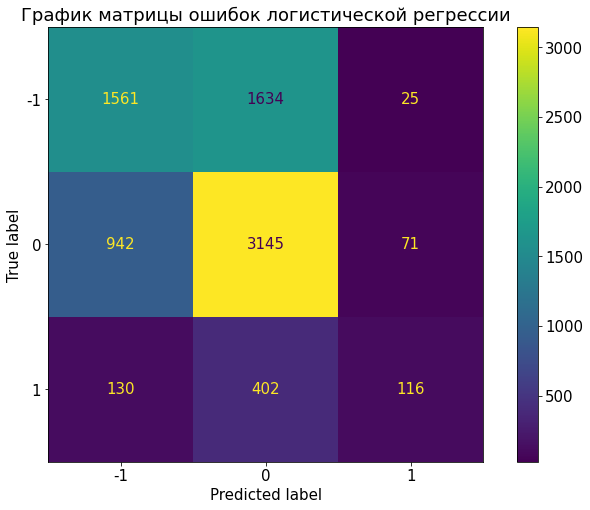

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title('График матрицы ошибок логистической регрессии')

cm = metrics.confusion_matrix(y_test, y_pred)
cmp = metrics.ConfusionMatrixDisplay(cm, display_labels=log_model.classes_)
cmp.plot(ax=ax)

plt.show();

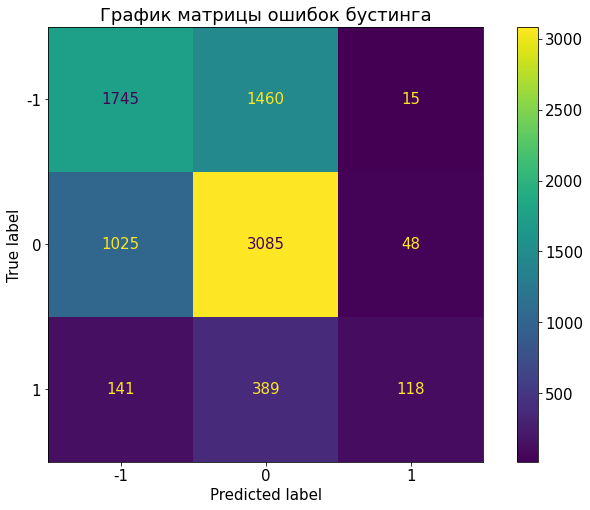

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title('График матрицы ошибок бустинга')

cm = metrics.confusion_matrix(y_test, y_pred_boosting)
cmp = metrics.ConfusionMatrixDisplay(cm, display_labels=best_model.classes_)
cmp.plot(ax=ax)

plt.show();

## Выводы

Исходя из графика матричцы ошибок, можно сделать выводы, что:
- Обе модели плохо предсказывают положительные комментарии
- Обе модели отдают предпочтение нейтральному классу
- Модель градиентного бустинга чуть лучше предсказывает негативные комментарии

Примерное сходство моделей подтверждают и метрики f1 и roc-auc

## Возможные улучшения качества
- Метод обучения один класс против всех других дал бы лучший результат
- Oversampling или undersampling помогли бы с несбалансированностью классов. В данном случае oversampling, так как положительных комментариев всего около 2000
- Использование RNN, так как Word2Vec в теории должен давать прирост на нейронных сетях 